In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [132]:
%cd /content/gdrive/My Drive/Colab Notebooks/Classification_Bankruptcy/5조

/content/gdrive/My Drive/Colab Notebooks/Classification_Bankruptcy/5조


In [4]:
df = pd.read_csv("imputed_final_deleted.csv")
df.shape

(6835, 31)

In [0]:
y = df['class']
X = df[df.columns[df.columns != 'class']]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=5)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train)

In [8]:
import joblib
import pickle

joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [0]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import warnings

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 5)
warnings.filterwarnings('ignore')

# 1. Logistic Regression

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid= {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg = LogisticRegression(class_weight='balanced')
logreg_cv = GridSearchCV(logreg, grid, cv=cv, scoring='f1')
logreg_cv.fit(X_train_scaled, y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("f1 score :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 100.0, 'penalty': 'l2'}
f1 score : 0.21217163032369976


In [11]:
from sklearn.base import clone

lr_clf = clone(logreg_cv.best_estimator_)
lr_clf.fit(X_train_scaled, y_train)

LogisticRegression(C=100.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lr_clf_score = cross_val_score(lr_clf, X_train_scaled, y_train, scoring='f1', cv=cv).mean()

In [13]:
lr_clf_score

0.21217163032369976

In [14]:
joblib.dump(lr_clf, "logistic.pkl")

['logistic.pkl']

# 1. SVM
## 1-1. Linear SVM

In [15]:
from sklearn.svm import SVC

svm_linear_clf = SVC(C=10, kernel="linear", class_weight='balanced', probability=True)
svm_linear_clf.fit(X_train_scaled, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
svm_linear_clf_score = cross_val_score(svm_linear_clf, X_train_scaled, y_train, scoring='f1', cv=cv).mean()

In [19]:
svm_linear_clf_score

0.22057820338161865

## 1-2. Kernel SVM

In [0]:
from sklearn.svm import SVC

svm_rbf = SVC(class_weight='balanced')
grid= {"C":np.logspace(-2,2,5), "gamma": np.logspace(-2, 2, 5)}
svm_rbf_cv = GridSearchCV(svm_rbf, grid, cv=cv, scoring='f1')
svm_rbf_cv.fit(X_train_scaled, y_train)

print("tuned hpyerparameters :(best parameters) ",svm_rbf_cv.best_params_)
print("f1 score :",svm_rbf_cv.best_score_)

In [0]:
svm_rbf_clf = clone(svm_rbf_cv.best_estimator_)
svm_rbf_clf.fit(X_train_scaled, y_train)

In [0]:
svm_rbf_clf_score = cross_val_score(svm_rbf_clf, X_train_scaled, y_train, scoring='f1', cv=cv).mean()

In [0]:
svm_rbf_clf_score

In [0]:
joblib.dump(svm_linear_clf, "SVM_linear.pkl")
joblib.dump(svm_rbf_clf, "SVM_rbf.pkl")

# 2. RandomForest

In [0]:
rf_clf = joblib.load("forest_01.pkl")

In [0]:
rf_clf_score = cross_val_score(rf_clf, X_train_scaled, y_train, scoring='f1', cv=cv).mean()

In [22]:
rf_clf_score

0.20035503699688448

# 3. XGBoost

In [23]:
!pip install xgboost --upgrade

Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (1.1.0)


In [24]:
import xgboost
from xgboost import XGBClassifier

assert xgboost.__version__ == "1.1.0"


xgb_clf = XGBClassifier(learning_rate=0.3, max_depth=10, min_child_weight=0.1, gamma=0.2, colsample_bytree=0.7)
xgb_clf.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=0.1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [0]:
xgb_clf.save_model('xgb.xgb')

In [0]:
from xgboost import Booster

booster = Booster()
booster.load_model('xgb.xgb')
new_xgb_clf = XGBClassifier(learning_rate=0.3, max_depth=10, min_child_weight=0.1, gamma=0.2, colsample_bytree=0.7)
new_xgb_clf._Booster = booster

In [0]:
xgb_clf_score = cross_val_score(new_xgb_clf, X_train_scaled, y_train, scoring='f1', cv=cv).mean()

In [28]:
xgb_clf_score

0.41325161278881156

# 4. FA XGBoost

In [0]:
! pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(n_factors = 6, rotation = 'varimax', bounds = (0, 1), method = 'principal')
X_fa = fa.fit_transform(X_train_scaled)

In [0]:
from xgboost import XGBClassifier

model = XGBClassifier(colsample_bytree= 0.5, eta= 0.05, gamma= 0.0, max_depth= 4, min_child_weight= 1)
model.fit(X_fa, y_train)

In [0]:
xgb_fa_clf_score = cross_val_score(model, X_fa, y_train, scoring='f1', cv=cv).mean()

In [0]:
xgb_fa_clf_score # 너무 구려서 뺌

In [0]:
total = sum((lr_clf_score, svm_linear_clf_score, rf_clf_score, xgb_clf_score))
scores = list(map(lambda x: x / total, [lr_clf_score, svm_linear_clf_score, rf_clf_score, xgb_clf_score]))

with open("scores.pkl", "wb") as f:
    pickle.dump(scores, f)

In [30]:
scores

[0.20277184083174057,
 0.21080597947431065,
 0.19147875524068947,
 0.39494342445325936]

In [31]:
test = pd.concat([X_test, y_test], axis=1)
test.shape

(1367, 31)

In [32]:
test.columns = df.columns
test.columns

Index(['Attr4', 'Attr5', 'Attr9', 'Attr12', 'Attr18', 'Attr21', 'Attr23',
       'Attr24', 'Attr27', 'Attr29', 'Attr33', 'Attr35', 'Attr36', 'Attr38',
       'Attr40', 'Attr43', 'Attr45', 'Attr47', 'Attr48', 'Attr49', 'Attr50',
       'Attr51', 'Attr52', 'Attr56', 'Attr58', 'Attr59', 'Attr60', 'Attr61',
       'Attr63', 'Attr64', 'class'],
      dtype='object')

In [0]:
test.to_csv("df_test.csv", index=False)

# 5. Evaluation
## 5-1. Train set

In [0]:
scaler = joblib.load('scaler.pkl')

X = scaler.transform(X_train)

In [0]:
# ensemble
lr_clf = joblib.load('logistic.pkl')
svm_clf = joblib.load('SVM_linear.pkl')
rf_clf = joblib.load('forest_01.pkl')
xgb_clf = XGBClassifier(learning_rate=0.3, max_depth=10, min_child_weight=0.1, gamma=0.2, colsample_bytree=0.7)
booster = Booster()
booster.load_model('xgb.xgb')
xgb_clf._Booster = booster

scores = pickle.load(open('scores.pkl', 'rb'))

lr_probs = lr_clf.predict_proba(X)
svm_probs = svm_clf.predict_proba(X)
rf_probs = rf_clf.predict_proba(X)
xgb_probs = xgb_clf.predict_proba(X)

In [0]:
def ensemble_predict():
    y_pred = np.empty(shape=(X.shape[0], ), dtype=np.int)
    for i in range(len(y_pred)):
        #pos = xgb_probs[i, 1]
        #neg = xgb_probs[i, 0]
        pos = lr_probs[i, 1] * scores[0] + svm_probs[i, 1] * scores[1] + rf_probs[i, 1] * scores[2] + xgb_probs[i, 1] * scores[3]
        neg = lr_probs[i, 0] * scores[0] + svm_probs[i, 0] * scores[1] + rf_probs[i, 0] * scores[2] + xgb_probs[i, 0] * scores[3]
        if pos > neg:
            y_pred[i] = 1
        else:
            y_pred[i] = 0

    y_pred = pd.DataFrame(y_pred)
    #y_pred.to_csv(file_name.rstrip(".csv") + "_" + "prediction.csv", index=False)

    return y_pred

In [0]:
y_train_pred = ensemble_predict()

In [51]:
from sklearn.metrics import f1_score

print(f1_score(y_train, y_train_pred))

1.0


In [0]:
#xgb only

def xgb_predict():
    y_pred = np.empty(shape=(X.shape[0], ), dtype=np.int)
    for i in range(len(y_pred)):
        pos = xgb_probs[i, 1]
        neg = xgb_probs[i, 0]
        #pos = lr_probs[i, 1] * scores[0] + svm_probs[i, 1] * scores[1] + rf_probs[i, 1] * scores[2] + xgb_probs[i, 1] * scores[3]
        #neg = lr_probs[i, 0] * scores[0] + svm_probs[i, 0] * scores[1] + rf_probs[i, 0] * scores[2] + xgb_probs[i, 0] * scores[3]
        if pos > neg:
            y_pred[i] = 1
        else:
            y_pred[i] = 0

    y_pred = pd.DataFrame(y_pred)
    #y_pred.to_csv(file_name.rstrip(".csv") + "_" + "prediction.csv", index=False)

    return y_pred


In [0]:
y_train_pred = xgb_predict()

In [54]:
print(f1_score(y_train, y_train_pred))

1.0


앙상블 모델, xgb 모두 트레인셋은 완벽하게 예측한다

## 5-2. Test set

In [0]:
X = scaler.transform(X_test)

In [0]:
lr_clf = joblib.load('logistic.pkl')
svm_clf = joblib.load('SVM_linear.pkl')
rf_clf = joblib.load('forest_01.pkl')
xgb_clf = XGBClassifier(learning_rate=0.3, max_depth=10, min_child_weight=0.1, gamma=0.2, colsample_bytree=0.7)
booster = Booster()
booster.load_model('xgb.xgb')
xgb_clf._Booster = booster

scores = pickle.load(open('scores.pkl', 'rb'))

lr_probs = lr_clf.predict_proba(X)
svm_probs = svm_clf.predict_proba(X)
rf_probs = rf_clf.predict_proba(X)
xgb_probs = xgb_clf.predict_proba(X)

In [64]:
# ensemble

y_test_pred = ensemble_predict()
print(f1_score(y_test, y_test_pred))

0.3636363636363636


In [65]:
# xgb

y_test_pred = xgb_predict()
print(f1_score(y_test, y_test_pred))

0.4337349397590362


테스트 셋에서 xgb가 더 좋으니 앙상블 대신 xgb를 사용하기로 결정

# 6. Visualization
## 6-1. Logistic Regression

In [0]:
def plot_vars(estimator):
    features = X_train.columns
    if "feature_importances_" in dir(estimator):
        coefs = estimator.feature_importances_
        top10 = np.argsort(-coefs)[:10]
        x = range(10)
        xlabel = [features[x_] for x_ in top10]

        plt.figure(figsize=(10, 6))
        plt.title(estimator.__class__.__name__)
        plt.xticks(x, xlabel)
        plt.bar(range(10), coefs[top10])
        plt.ylabel("Feature importances")
    else:
        coefs = estimator.coef_[0]
        # positive
        top5 = np.argsort(-coefs)[:5]
        # negative
        bottom5 = np.argsort(coefs)[:5]

        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        plt.title(estimator.__class__.__name__)
        x = range(5)
        xlabel = [features[x_] for x_ in top5]
        plt.xticks(x, xlabel)
        plt.bar(range(5), coefs[top5])
        plt.ylabel("Positive Coefs")


        plt.subplot(1, 2, 2)
        plt.title(estimator.__class__.__name__)
        x = range(5)
        xlabel = [features[x_] for x_ in bottom5]
        plt.xticks(x, xlabel)
        plt.bar(range(5), coefs[bottom5])
        plt.ylabel("Negative Coefs")

    plt.tight_layout()


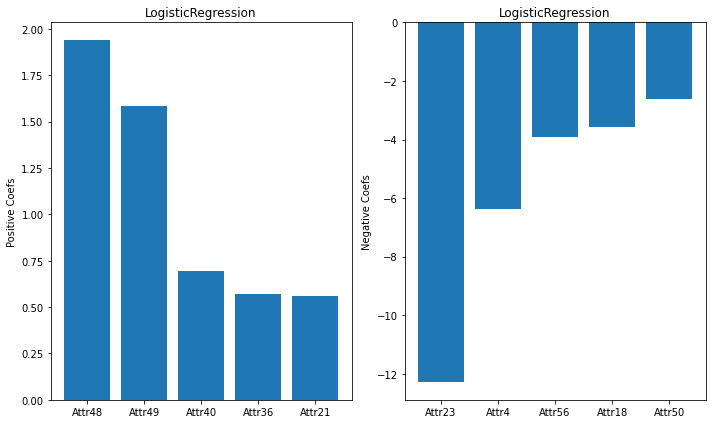

In [124]:
plot_vars(lr_clf)

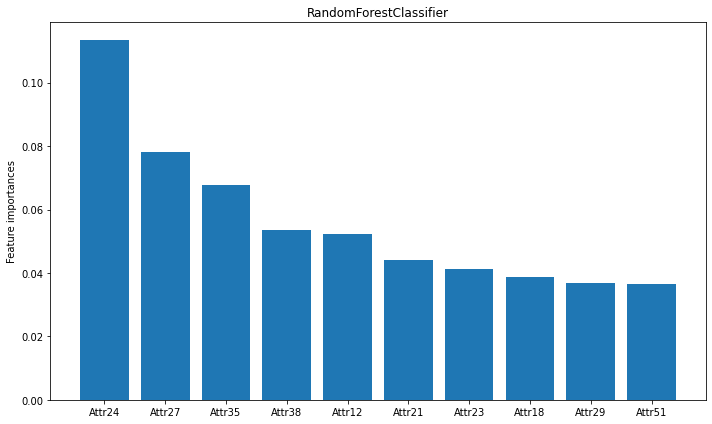

In [125]:
plot_vars(rf_clf)

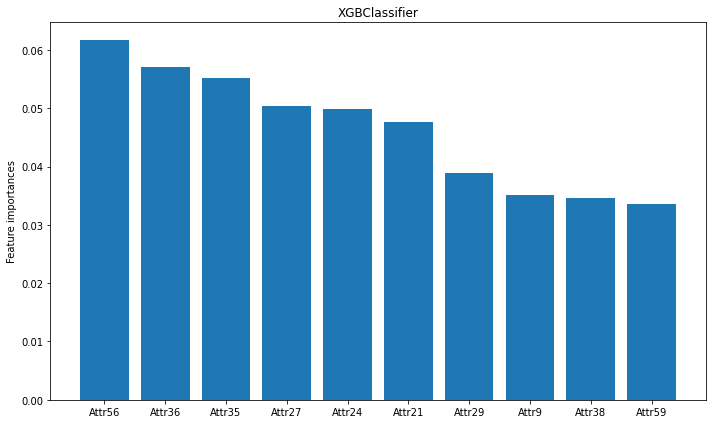

In [126]:
plot_vars(xgb_clf)

# 7. Prediction

In [134]:
!ls

df_test.csv				    logistic.pkl
EDA_정재은_FA.ipynb			    median_imputer.pkl
EDA_정재은_final_NA_impute.ipynb	    Modeling_with_FA_정재은.ipynb
EDA.ipynb				    na_filled_train.csv
EDA_홍익선_NA_impute.ipynb		    outlier_removed_train.csv
EDA_김윤전_preprocess.ipynb		    Random_Forest_CV.ipynb
FactorAnalysisXGboostClassification.ipynb   README.txt
FA_model_xgboost.pkl			    scaler.pkl
fa.pkl					    scores.pkl
forest_01.pkl				    SVM_linear.pkl
FS_2y_before_Bankruptcy_test_x_imputed.csv  SVM_rbf.pkl
grid1.pkl				    train.csv
grid2.pkl				    xgb_01.pkl
imputed_final.csv			    xgb_clf.pkl
imputed_final_deleted.csv		    xgb_fa.pkl
모델링_정재은.ipynb			    xgb.pkl
변수제거_정재은.ipynb			    xgb.xgb
LinearSVC.ipynb


In [135]:
test = pd.read_csv("FS_2y_before_Bankruptcy_test_x_imputed.csv")
test.head()

,Attr4,Attr5,Attr9,Attr12,Attr18,Attr21,Attr23,Attr24,Attr27,Attr29,Attr33,Attr35,Attr36,Attr38,Attr40,Attr43,Attr45,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr56,Attr58,Attr59,Attr60,Attr61,Attr63,Attr64
0,1.88520,48.8550,1.1259,0.308557,0.073958,1.1798,0.050143,0.185190,1.27830,4.8487,3.0618,0.093813,0.83286,0.68877,0.033724,196.040,0.50213,55.921,0.042228,0.037506,0.86082,0.23969,0.32660,0.111840,0.88816,0.884147,7.3490,2.4937,4.697317,1.5075
1,1.85090,4.2847,2.4700,-0.029984,-0.008610,1.0919,-0.003486,0.019968,0.73304,3.9952,8.8357,-0.067243,2.47000,0.59141,0.580050,53.929,-0.04301,28.799,-0.150140,-0.060785,0.94740,0.28716,0.11318,-0.027224,1.00340,0.623855,12.3380,14.9920,8.601477,5.2723
2,3.07500,-5.6058,1.1013,0.719073,0.119100,1.0630,0.084026,0.196080,1.01840,4.5307,6.9216,0.116760,1.30720,0.81936,0.194570,137.930,0.25701,114.640,0.028096,0.025512,0.92338,0.16563,0.14448,0.091953,0.90805,0.925084,3.5064,10.7890,6.649158,2.5729
3,0.89587,-64.4640,1.0040,0.060648,0.029819,1.1532,0.064843,0.029819,1.01190,4.9313,2.8437,0.039231,1.53440,0.39507,0.018673,112.150,0.34203,49.691,-0.005171,-0.005151,0.55250,0.49167,0.35166,0.003939,0.99606,4.679601,7.3744,5.8256,2.042020,2.5086
4,1.99420,39.9890,2.6600,0.666227,0.298210,1.7786,0.087748,0.587660,22.89100,3.4163,5.2545,0.308020,2.66000,0.52053,1.343100,39.993,1.37720,26.302,0.270720,0.101774,1.77320,0.44761,0.19031,0.115800,0.88972,0.112344,15.6950,21.8080,5.942673,24.7730


In [146]:
test.columns = ['f' + str(i) for i in range(30)]
xgb_clf.predict_proba(test).shape

(2937, 2)

In [168]:
(xgb_clf.predict(test) > 0.5).sum()

0

밍..? threshold를 새로 정해주자

In [170]:
df['class'].value_counts() / len(df)

0.0    0.947184
1.0    0.052816
Name: class, dtype: float64

In [205]:
(xgb_clf.predict(test) > 0.0714).sum() / len(test)

0.052774940415389854

threshold를 새로 정해줌

In [0]:
threshold = 0.0714

In [0]:
#xgb only
def xgb_infer(X, file_name):
    y_pred = np.empty(shape=(X.shape[0], ), dtype=np.int)
    for i in range(len(y_pred)):
        xgb_probs = xgb_clf.predict_proba(X)
        pos = xgb_probs[i, 1]
        neg = xgb_probs[i, 0]
        if pos > threshold:
            y_pred[i] = 1
        else:
            y_pred[i] = 0

    y_pred = pd.DataFrame(y_pred)
    y_pred.to_csv(file_name, index=False)

    return y_pred


In [0]:
test_pred = xgb_infer(test, file_name="FS_2y_before_Bankruptcy_test_y.csv")

In [209]:
test_pred[0].value_counts()

0    2782
1     155
Name: 0, dtype: int64

In [210]:
test_pred[0].value_counts() / len(test_pred)

0    0.947225
1    0.052775
Name: 0, dtype: float64